## Linear Regression

Equation 4-3. MSE cost function for a linear regression model  

$$
\text{MSE}(X, \theta) 
= 
\frac{1}{m} \sum_{i=1}^{m} \left( \theta^\top x^{(i)} - y^{(i)} \right)^2
$$

### The Normal Equation

To find the value of θ that minimizes the cost function, there is a closed-form solution. In other words, a mathematical equation that gives the result directly. This is called the Normal Equation (Equation 4-4).  
Equation 4-4. Normal Equation  
θ = (X<sup>⊺</sup> X)<sup>−1</sup> X<sup>⊺</sup> y  
In this equation:  
θ is the value of θ that minimizes the cost function.  
y is the vector of target values containing y(1) to y(m).  
Let’s generate some linear-looking data to test this equation on (Figure 4-1)

In [35]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
m = 100 # number of instances
X = 2 * np.random.rand(m, 1) # 100 by 1 matrix of randoms (0 to 2)
y = 4 + 3 * X + np.random.randn(100, 1) # labels, last term is to add some noise

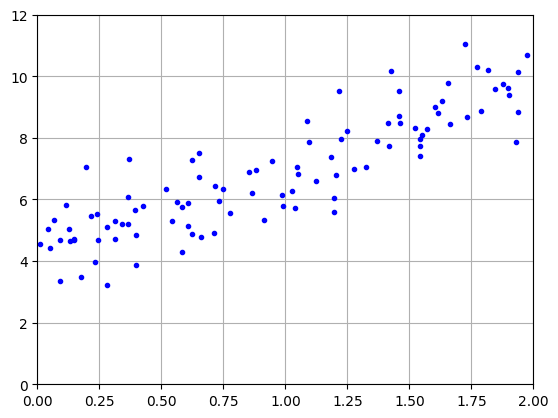

In [36]:
plt.grid()
plt.axis([0, 2, 0, 12])
plt.plot(X, y, "b.")

In [37]:
X_b = np.c_[np.ones((100, 1)), X] # x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T @ X_b) @ (X_b.T) @ (y) # @ does matrix multiplication

The function we used to calculate y values is 4 + 3 * X + random(Gaussian noise).  
Lets see what the equation found:

In [38]:
theta_best

array([[4.21509616],
       [2.77011339]])

We would have hoped for θ0 = 4 and θ1 = 3. Close enough, but the noise made it impossible to recover the exact parameters of the original function. Now lets make predictions using θ:

In [40]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2,1)), X_new]
y_predict = X_new_b @ theta_best
y_predict

array([[4.21509616],
       [9.75532293]])

Let’s plot this model’s predictions

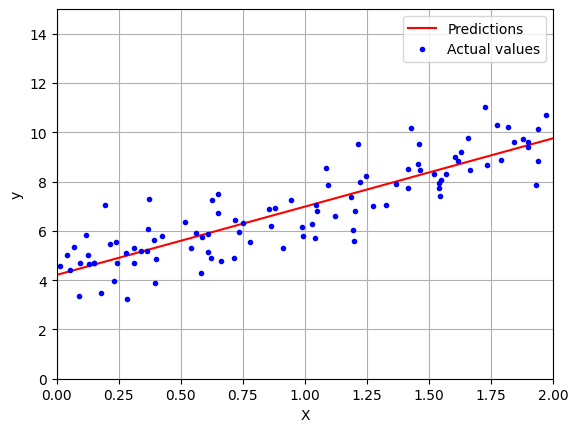

In [41]:
plt.plot(X_new, y_predict, "r-", label="Predictions")
plt.plot(X, y, "b.", label="Actual values")
plt.xlabel("X")
plt.ylabel("y")
plt.grid(True)
plt.legend()
plt.axis([0, 2, 0, 15])
plt.show()

Performing Linear Regression using Scikit-Learn is simple: 

In [42]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

In [43]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

The LinearRegression class is based on the scipy.linalg.lstsq() function (the
name stands for “least squares”), which you could call directly:

In [44]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.21509616],
       [2.77011339]])

This function computes θ = X<sup>+</sup>y,  
where X<sup>+</sup> is the pseudoinverse of X (specifically, the Moore-Penrose inverse). You can use np.linalg.pinv() to compute the pseudoinverse directly:

In [45]:
np.linalg.pinv(X_b) @ y

array([[4.21509616],
       [2.77011339]])

The pseudoinverse itself is computed using a standard matrix factorization technique
called Singular Value Decomposition (SVD) that can decompose the training set
matrix X into the matrix multiplication of three matrices U Σ V⊺
(see
numpy.linalg.svd()). The pseudoinverse is computed as X+ = V Σ+ U⊺.  
To compute
the matrix Σ+, the algorithm takes Σ and sets to zero all values smaller than a tiny
threshold value, then it replaces all the nonzero values with their inverse, and finally
it transposes the resulting matrix. This approach is more efficient than computing the
Normal Equation, plus it handles edge cases nicely: indeed, the Normal Equation may
not work if the matrix X⊺X is not invertible (i.e., singular), such as if m < n or if some
features are redundant, but the pseudoinverse is always defined.


Computational Complexity  
The Normal Equation computes the inverse of X⊺ X, which is an (n + 1) × (n + 1) matrix (where n is the number of features). The computational complexity of inverting such a matrix is typically about O(n<sup>2.4</sup>) to O(n<sup>3</sup>), depending on the implementation. In other words, if you double the number of features, you multiply the computation time by roughly 2<sup>2.4</sup> = 5.3 to 2<sup>3</sup> = 8.
The SVD approach used by Scikit-Learn’s LinearRegression class is about O(n<sup>2</sup>). If you double the number of features, you multiply the computation time by roughly 4.

Note:  
Both the Normal Equation and the SVD approach get very slow
when the number of features grows large (e.g., 100,000). On the
positive side, both are linear with regard to the number of instances
in the training set (they are O(m)), so they handle large training
sets efficiently, provided they can fit in memory.

Also, once you have trained your Linear Regression model (using the Normal Equation or any other algorithm), predictions are very fast: the computational complexity
is linear with regard to both the number of instances you want to make predictions
on and the number of features. In other words, making predictions on twice as many
instances (or twice as many features) will take roughly twice as much time.
Now we will look at a very different way to train a Linear Regression model, which is
better suited for cases where there are a large number of features or too many training
instances to fit in memory.

## Gradient Descent

Fortunately, the MSE cost function for a linear regression model happens to be a
convex function, which means that if you pick any two points on the curve, the line
segment joining them is never below the curve. This implies that there are no local
minima, just one global minimum. It is also a continuous function with a slope that
never changes abruptly.
These two facts have a great consequence: gradient descent
is guaranteed to approach arbitrarily closely the global minimum (if you wait long
enough and if the learning rate is not too high).  

While the cost function has the shape of a bowl, it can be an elongated bowl if the
features have very different scales. Figure 4-7 shows gradient descent on a training set
where features 1 and 2 have the same scale (on the left), and on a training set where
feature 1 has much smaller values than feature 2 (on the right).

As you can see, on the left the gradient descent algorithm goes straight toward the
minimum, thereby reaching it quickly, whereas on the right it first goes in a direction
almost orthogonal to the direction of the global minimum, and it ends with a long
march down an almost flat valley. It will eventually reach the minimum, but it will
take a long time.  

When using gradient descent, you should ensure that all features
have a similar scale (e.g., using Scikit-Learn’s StandardScaler
class), or else it will take much longer to converge.  

This diagram also illustrates the fact that training a model means searching for a
combination of model parameters that minimizes a cost function (over the training
set). It is a search in the model’s parameter space. The more parameters a model
has, the more dimensions this space has, and the harder the search is: searching
for a needle in a 300-dimensional haystack is much trickier than in 3 dimensions.
Fortunately, since the cost function is convex in the case of linear regression, the
needle is simply at the bottom of the bowl.


### Batch Gradient Descent  

To implement gradient descent, you need to compute the gradient of the cost function with regard to each model parameter θj
. In other words, you need to calculate
how much the cost function will change if you change θj
just a little bit. This is called
a partial derivative. It is like asking, “What is the slope of the mountain under my
feet if I face east”? and then asking the same question facing north (and so on for all
other dimensions, if you can imagine a universe with more than three dimensions).
Equation 4-5 computes the partial derivative of the MSE with regard to parameter θj
,
noted ∂ MSE(θ) / ∂θj.  

$$
\text{MSE}(\theta) 
= 
\frac{1}{m} \sum_{i=1}^{m} \left( \theta^\top x^{(i)} - y^{(i)} \right)^2
$$

$$
\frac{\partial}{\partial \theta_j} \mathrm{MSE}(\theta)
=
\frac{2}{m}
\sum_{i=1}^{m}
\left( \theta^{\top} x^{(i)} - y^{(i)} \right) x_j^{(i)}
$$

Instead of computing these partial derivatives individually, you can use Equation 4-6
to compute them all in one go. The gradient vector, noted $\nabla_\theta \text{MSE}(\theta)$, contains all the
partial derivatives of the cost function (one for each model parameter).

Equation 4-6. Gradient vector of the cost function

$$
\nabla_\theta \text{MSE}(\theta) =
\begin{bmatrix}
\frac{\partial}{\partial \theta_0} \text{MSE}(\theta) \\
\frac{\partial}{\partial \theta_1} \text{MSE}(\theta) \\
\vdots \\
\frac{\partial}{\partial \theta_n} \text{MSE}(\theta)
\end{bmatrix}
=
\frac{2}{m} X^\top (X \theta - y)
$$

Notice that this formula involves calculations over the full training
set $X$ at each gradient descent step. This is why the algorithm is called batch gradient descent: it uses the whole batch of training
data at every step (actually, full gradient descent would probably
be a better name). As a result, it is terribly slow on very large
training sets (we will look at some much faster gradient descent
algorithms shortly). However, gradient descent scales well with the
number of features; training a linear regression model when there
are hundreds of thousands of features is much faster using gradient
descent than using the Normal equation or SVD decomposition.  

Simple Summary:  
At each step, it calculates partial derivatives with respect to each model parameter (which is equal to the number of features) using the whole training set.  

- If the training set size increases (say doubles), it takes double the time at each step.  
- If the number of features increases, the computation time per step increases linearly with the number of features, because we need to compute a partial derivative for each feature.  

In other words, batch gradient descent is sensitive to dataset size, but scales relatively well with the number of features.

Once you have the gradient vector, which points uphill, just go in the opposite
direction to go downhill. This means subtracting $\nabla_\theta \text{MSE}(\theta)$ from $\theta$. This is where the learning rate $\eta$ comes into play: multiply the gradient vector by $\eta$ to determine the
size of the downhill step (Equation 4-7).

Equation 4-7. Gradient descent step

$$
\theta_{\text{next step}} = \theta - \eta \nabla_\theta \text{MSE}(\theta)
$$

Let’s look at a quick implementation of this algorithm:


In [47]:
eta = 0.1 # learning rate hyperparameter
n_epochs = 1000
m = len(X_b)

np.random.seed(42)
theta = np.random.randn(2, 1) # random initial model parameter

for epoch in range(n_epochs):
    gradients = 2 / m * X_b.T @ (X_b @ theta - y)
    theta = theta - eta * gradients

In [48]:
theta

array([[4.21509616],
       [2.77011339]])

Hey, that’s exactly what the Normal equation found! Gradient descent worked per‐
fectly. But what if you had used a different learning rate (eta)? Figure 4-8 shows
the first 20 steps of gradient descent using three different learning rates. The line
at the bottom of each plot represents the random starting point, then each epoch is
represented by a darker and darker line.  

To find a good learning rate, you can use grid search (see Chapter 2). However, you
may want to limit the number of epochs so that grid search can eliminate models that
take too long to converge.  

You may wonder how to set the number of epochs. If it is too low, you will still be
far away from the optimal solution when the algorithm stops; but if it is too high,
you will waste time while the model parameters do not change anymore. A simple
solution is to set a very large number of epochs but to interrupt the algorithm when
the gradient vector becomes tiny—that is, when its norm becomes smaller than a
tiny number ϵ (called the tolerance)—because this happens when gradient descent has
(almost) reached the minimum.

Convergence Rate  

When the cost function is convex and its slope does not change abruptly (as is the
case for the MSE cost function), batch gradient descent with a fixed learning rate will
eventually converge to the optimal solution, but you may have to wait a while: it can
take O(1/ϵ) iterations to reach the optimum within a range of ϵ, depending on the
shape of the cost function. If you divide the tolerance by 10 to have a more precise
solution, then the algorithm may have to run about 10 times longer

### Stochastic Gradient Descent 

The main problem with batch gradient descent is the fact that it uses the whole
training set to compute the gradients at every step, which makes it very slow when
the training set is large. At the opposite extreme, stochastic gradient descent picks a
random instance in the training set at every step and computes the gradients based
only on that single instance. Obviously, working on a single instance at a time makes
the algorithm much faster because it has very little data to manipulate at every
iteration. It also makes it possible to train on huge training sets, since only one
instance needs to be in memory at each iteration (stochastic GD can be implemented
as an out-of-core algorithm; see Chapter 1).  

On the other hand, due to its stochastic (i.e., random) nature, this algorithm is
much less regular than batch gradient descent: instead of gently decreasing until it
reaches the minimum, the cost function will bounce up and down, decreasing only
on average. Over time it will end up very close to the minimum, but once it gets there
it will continue to bounce around, never settling down (see Figure 4-9). Once the
algorithm stops, the final parameter values will be good, but not optimal.  

When the cost function is very irregular (as in Figure 4-6), this can actually help
the algorithm jump out of local minima, so stochastic gradient descent has a better
chance of finding the global minimum than batch gradient descent does.  

Therefore, randomness is good to escape from local optima, but bad because it means
that the algorithm can never settle at the minimum. One solution to this dilemma
is to gradually reduce the learning rate. The steps start out large (which helps make
quick progress and escape local minima), then get smaller and smaller, allowing
the algorithm to settle at the global minimum. This process is akin to simulated
annealing, an algorithm inspired by the process in metallurgy of annealing, where
molten metal is slowly cooled down. The function that determines the learning rate at each iteration is called the learning schedule. If the learning rate is reduced too
quickly, you may get stuck in a local minimum, or even end up frozen halfway to
the minimum. If the learning rate is reduced too slowly, you may jump around the
minimum for a long time and end up with a suboptimal solution if you halt training
too early.  

This code implements stochastic gradient descent using a simple learning schedule:

In [49]:
n_epochs = 50
t0, t1 = 5, 50 # learning schedule hyperparameters
m = len(X_b)

def learning_schedule(t):
    return t0 / (t + t1)

np.random.seed(42)
theta = np.random.randn(2, 1) 

for epoch in range(n_epochs):
    for iteration in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index : random_index + 1]
        yi = y[random_index : random_index + 1]
        gradients = 2 * xi.T @ (xi @ theta - yi) # for SGD do not divide by m
        eta = learning_schedule(epoch * m + iteration)
        theta = theta - eta * gradients

While the batch gradient descent code iterated 1,000 times through the whole
training set, this code goes through the training set only 50 times and reaches a pretty
good solution:

In [50]:
theta

array([[4.21076011],
       [2.74856079]])

To perform linear regression using stochastic GD with Scikit-Learn, you can use
the SGDRegressor class, which defaults to optimizing the MSE cost function. The
following code runs for maximum 1,000 epochs (max_iter) or until the loss drops by
less than 10–5 (tol) during 100 epochs (n_iter_no_change). It starts with a learning
rate of 0.01 (eta0), using the default learning schedule (different from the one we
used). Lastly, it does not use any regularization (penalty=None; more details on this
shortly):

In [51]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-5, penalty=None, eta0=0.01, n_iter_no_change=100, random_state=42)
sgd_reg.fit(X, y.ravel())

,loss,'squared_error'
,penalty,None
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,1e-05
,shuffle,True
,verbose,0
,epsilon,0.1
,random_state,42


In [52]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.21278812]), array([2.77270267]))

### Mini-Batch Gradient Descent 

The last gradient descent algorithm we will look at is called mini-batch gradient
descent. It is straightforward once you know batch and stochastic gradient descent:
at each step, instead of computing the gradients based on the full training set (as in
batch GD) or based on just one instance (as in stochastic GD), mini-batch GD com‐
putes the gradients on small random sets of instances called mini-batches. The main
advantage of mini-batch GD over stochastic GD is that you can get a performance
boost from hardware optimization of matrix operations, especially when using GPUs.

Comparison:  

| Algorithm        | Large m | Out-of-core support | Large n | Hyperparams | Scaling required | Scikit-Learn       |
|-----------------|---------|-------------------|---------|------------|----------------|------------------|
| Normal equation  | Fast    | No                | Slow    | 0          | No             | N/A              |
| SVD              | Fast    | No                | Slow    | 0          | No             | LinearRegression |
| Batch GD         | Slow    | No                | Fast    | 2          | Yes            | N/A              |
| Stochastic GD    | Fast    | Yes               | Fast    | ≥2         | Yes            | SGDRegressor     |
| Mini-batch GD    | Fast    | Yes               | Fast    | ≥2         | Yes            | N/A              |

## Polynomial Regression

What if your data is more complex than a straight line? Surprisingly, you can use a
linear model to fit nonlinear data. A simple way to do this is to add powers of each
feature as new features, then train a linear model on this extended set of features. This
technique is called polynomial regression  

Let’s look at an example. First, we’ll generate some nonlinear data (see Figure 4-12),
based on a simple quadratic equation—that’s an equation of the form y = ax² + bx +
c—plus some noise:  

In [56]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1)

Text(0, 0.5, 'y')

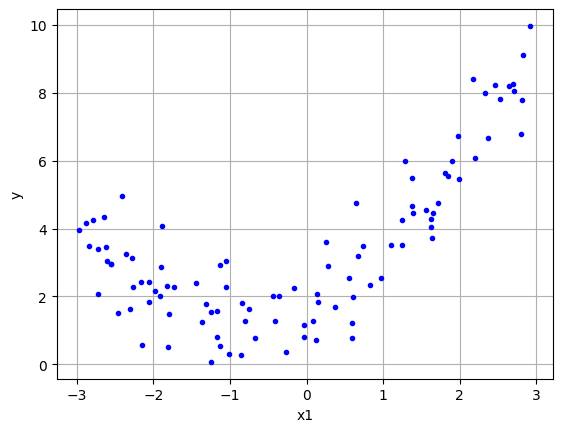

In [58]:
plt.grid()
plt.plot(X, y, "b.")
plt.xlabel("x1")
plt.ylabel("y")

Clearly, a straight line will never fit this data properly. So let’s use Scikit-Learn’s
PolynomialFeatures class to transform our training data, adding the square (second degree polynomial) of each feature in the training set as a new feature (in this case
there is just one feature):

In [68]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
print(X[0]) # original
print(X_poly[0]) # original and its square

[-0.75275929]
[-0.75275929  0.56664654]


Now we can fit a LinearRegression model to this extended training data

In [69]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

Not bad: the model estimates y = 0.56x1<sup>2</sup>+ 0.93x1 + 1.78 when in fact the original function was y = 0.5x1<sup>2</sup>+ 1.0x1 + 2.0 + Gaussian noise.
Note that when there are multiple features, polynomial regression is capable of
finding relationships between features, which is something a plain linear regression
model cannot do. This is made possible by the fact that PolynomialFeatures also
adds all combinations of features up to the given degree. For example, if there were
two features a and b, PolynomialFeatures with degree=3 would not only add the
features a
2
, a
3
, b
2
, and b
3
, but also the combinations ab, a
2b, and ab2
.

In [83]:
y_predict = lin_reg.predict(X_poly)

In [84]:
sorted_idx = np.argsort(X.ravel())

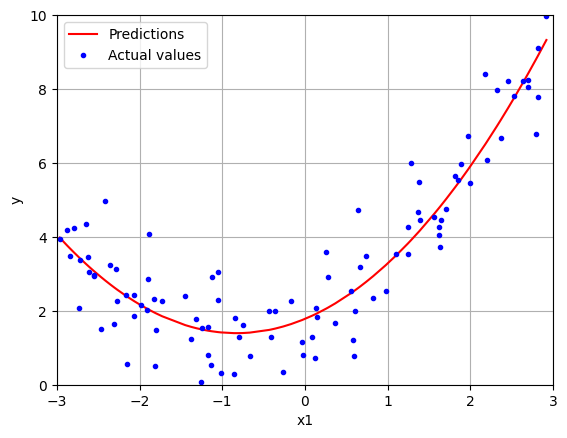

In [85]:
plt.plot(X[sorted_idx], y_predict[sorted_idx], "r-", label="Predictions")
plt.plot(X[sorted_idx], y[sorted_idx], "b.", label="Actual values")
plt.xlabel("x1")
plt.ylabel("y")
plt.axis([-3, 3, 0, 10])
plt.grid(True)
plt.legend()
plt.show()

## Learning Curves